In [1]:
# --- a. Import the necessary packages ---

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam # Switched to Adam for better CNN performance
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
def load_and_preprocess_data(filepath, num_classes=10, image_size=(28, 28, 1)):

    # 1. Load the dataset
    print(f"Loading data from: {filepath}...")
    data = pd.read_csv(filepath)

    # 2. Separate features (pixels) and target (label)
    X = data.iloc[:, 1:].values.astype('float32') # Pixel data starts from the second column
    y = data['label'].values

    # 3. Reshape the data for CNN: (samples, 784) -> (samples, 28, 28, 1)
    # The '1' denotes a single colour channel (grayscale)
    X = X.reshape(X.shape[0], *image_size)

    # 4. Normalise the pixel data: Scale to the range [0, 1]
    # MNIST pixels are 0 to 255 (unsigned 8-bit integers)
    X /= 255.0

    # . One-hot encode the target labels
    y = to_categorical(y, num_classes=num_classes)
    print(data.info())
    print(data.head())
    return X, y

In [3]:
# Load the training and testing data

X_train, y_train = load_and_preprocess_data(r"C:\Users\hp\OneDrive\Desktop\LP4\MNIST\MNIST_Ass2_and_Ass3\mnist_train.csv")
X_test, y_test = load_and_preprocess_data(r"C:\Users\hp\OneDrive\Desktop\LP4\MNIST\MNIST_Ass2_and_Ass3\mnist_test.csv")

Loading data from: C:\Users\hp\OneDrive\Desktop\LP4\MNIST\MNIST_Ass2_and_Ass3\mnist_train.csv...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB
None
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0   

In [4]:
# --- b. Defining the model's architecture ---
model = Sequential()
# First Convolutional Block
model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1), activation = "relu", name = "Conv_1"))
model.add(MaxPooling2D((2, 2), name = "Pool_1"))
# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation = "relu", name = "Conv_2"))
model.add(MaxPooling2D((2, 2), name = "Pool_2"))
# Classification Head (Feedforward/Dense Layers)
model.add(Flatten(name = "Flatten_Layer")) # Flatten feature maps to a vector
model.add(Dense(100, activation = "relu", name = "Dense_1"))
model.add(Dense(10, activation = "softmax", name = "Output_Layer")) # Output 10 classes

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile the model
# We use the Adam optimizer and the categorical crossentropy loss
adam = Adam(0.001)
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_1 (MaxPooling2D)           │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_2 (MaxPooling2D)           │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,926 (702.84 KB)

 Trainable params: 179,926 (702.84 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# --- c. Training the model ---
epochs = 10
H = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = 128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9319 - loss: 0.2277 - val_accuracy: 0.9799 - val_loss: 0.0639
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9817 - loss: 0.0583 - val_accuracy: 0.9867 - val_loss: 0.0397
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9870 - loss: 0.0416 - val_accuracy: 0.9871 - val_loss: 0.0342
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9900 - loss: 0.0326 - val_accuracy: 0.9869 - val_loss: 0.0385
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9918 - loss: 0.0259 - val_accuracy: 0.9907 - val_loss: 0.0288
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.9916 - val_loss: 0.0249
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9911 - val_loss: 0.0255
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9956 - loss: 0.0142 - 

In [7]:
# --- d. Estimating the model's performance ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9911 - loss: 0.0288
Test Loss: 0.0288
Test Accuracy: 0.99


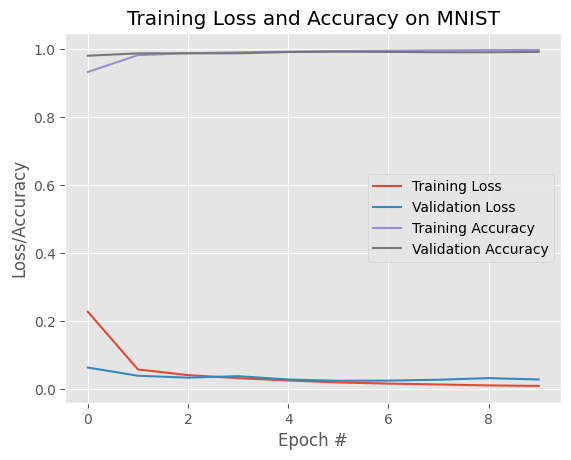

In [8]:
# Plotting the training progress
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, 10), H.history["loss"], label="Training Loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, 10), H.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy on MNIST")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [2]:
def load_and_process_data(filepath, num_classes = 10, image_size = (28, 28, 1)):
    data = pd.read_csv(filepath)
    X = data.iloc[:, 1:].values.astype('float32')
    y = data['label'].values
    X = X.reshape(X.shape[0], *image_size)
    X = X / 255.0
    y = to_categorical(y, num_classes = num_classes)
    return X, y

In [3]:
X_train, y_train = load_and_process_data(r"C:\Users\hp\OneDrive\Desktop\LP4\MNIST\MNIST_Ass2_and_Ass3\mnist_train.csv")
X_test, y_test = load_and_process_data(r"C:\Users\hp\OneDrive\Desktop\LP4\MNIST\MNIST_Ass2_and_Ass3\mnist_test.csv")

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu", name = "Conv_1"))
model.add(MaxPooling2D((2, 2), name = "Pool_1"))
model.add(Conv2D(64, (3, 3), activation = "relu", name = "Conv_2"))
model.add(MaxPooling2D((2, 2), name = "Pool_2"))

model.add(Flatten(name = "Flatten_Layer"))
model.add(Dense(100, activation = "relu", name = "Dense_1"))
model.add(Dense(10, activation = "softmax", name = "Dense_2"))

In [5]:
adam = Adam(0.001)
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

epochs = 10
H = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = 128)
model.summary()

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9340 - loss: 0.2267 - val_accuracy: 0.9792 - val_loss: 0.0674
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9824 - loss: 0.0588 - val_accuracy: 0.9868 - val_loss: 0.0441
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9873 - loss: 0.0420 - val_accuracy: 0.9879 - val_loss: 0.0369
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9905 - loss: 0.0314 - val_accuracy: 0.9890 - val_loss: 0.0308
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9926 - loss: 0.0247 - val_accuracy: 0.9894 - val_loss: 0.0319
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9934 - loss: 0.0210 - val_accuracy: 0.9889 - val_loss: 0.0326
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9947 - loss: 0.0171 - val_accuracy: 0.9905 - val_loss: 0.0267
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9960 - loss: 0.0134 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_1 (MaxPooling2D)           │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_2 (MaxPooling2D)           │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,780 (2.06 MB)

 Trainable params: 179,926 (702.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 359,854 (1.37 MB)

In [6]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy * 100)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9907 - loss: 0.0322
0.03222588449716568
99.07000064849854


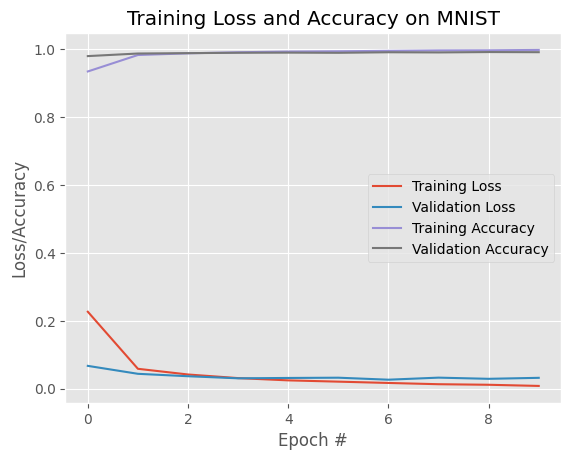

In [7]:
# Plotting the training progress
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, 10), H.history["loss"], label="Training Loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, 10), H.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="Validation Accuracy")

plt.title("Training Loss and Accuracy on MNIST")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()